In [1]:
import requests
import pandas as pd
import tweepy
import os
import json
import sys
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from functools import reduce
from datetime import datetime
from bs4 import BeautifulSoup

%matplotlib inline
np.random.seed = 42

Read the given csv archive.

In [2]:
df_main = pd.read_csv('twitter-archive-enhanced.csv')
df_main.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
df_main.shape

(2356, 17)

Download image predictions data and save it into a csv file.

In [4]:
# r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
# with open('image_predictions.tsv', 'w') as image_predictions_file:
#     image_predictions_file.write(r.text)

In [5]:
df_predictions = pd.read_csv('image_predictions.tsv', '\t')

In [6]:
df_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [7]:
df_predictions.shape

(2075, 12)

Now let's connect to Twitter API and get an instance of tweepy.API object. All Twitter Developer credentials are stored on the system.

In [8]:
# auth = tweepy.OAuthHandler(os.environ['TWITTER_CONS_API_KEY'], os.environ['TWITTER_CONS_API_SECRET'])
# auth.set_access_token(os.environ['TWITTER_ACCESS_TOKEN'], os.environ['TWITTER_ACCESS_SECRET'])

# api = tweepy.API(auth)

In [9]:
# counter = 1
# failed_tweets = []
# num_tweets = len(df_main.tweet_id)
# with open('tweet_json.txt', 'w') as tweet_json:
#     for tweet_id in df_main.tweet_id:
#         try:
#             data = api.get_status(tweet_id)._json
#             tweet_json.write(json.dumps(data))
#             tweet_json.write('\n')
#         except:
#             failed_tweets.append(tweet_id)
#         # print the percentage of tweets processed and move caret back to the start of the line
#         # to overwrite on next print
#         print('{:3.0%}'.format(counter / num_tweets), end='\r', flush=True)
#         counter += 1

Test the processing.

In [10]:
# with open('tweet_json.txt', 'r') as tweet_json:
#     assert len(df_main.tweet_id) == len(list(tweet_json)) + len(failed_tweets)

In [11]:
# len(failed_tweets)

In [12]:
df_tweet_data = pd.DataFrame(columns=['tweet_id', 'likes', 'retweets'])
with open('tweet_json.txt', 'r') as tweet_json:
    for line in tweet_json:
        tweet_j = json.loads(line)
        df_tweet_data = df_tweet_data.append(pd.DataFrame({
            'tweet_id': tweet_j['id'],
            'likes': tweet_j['favorite_count'],
            'retweets': tweet_j['retweet_count']
        }, index=[0]), ignore_index=True)

df_tweet_data.dtypes

tweet_id    object
likes       object
retweets    object
dtype: object

We need to convert `likes` and `retweets` to numeric type.

In [13]:
df_tweet_data.likes = pd.to_numeric(df_tweet_data.likes)
df_tweet_data.retweets = pd.to_numeric(df_tweet_data.retweets)
df_tweet_data.dtypes

tweet_id    object
likes        int64
retweets     int64
dtype: object

In [14]:
df_tweet_data.head()

,tweet_id,likes,retweets
0,892420643555336193,38198,8368
1,892177421306343426,32751,6178
2,891815181378084864,24667,4089
3,891689557279858688,41524,8495
4,891327558926688256,39715,9208


# Data Assessment

## Quality Issues

1. `doggo`, `pupper`, `puppo` and `floofer` have type string with only two observation values per column.

In [15]:
print(df_main[['doggo', 'pupper', 'puppo', 'floofer']].dtypes)
print(df_main.doggo.unique())
print(df_main.pupper.unique())
print(df_main.puppo.unique())
print(df_main.floofer.unique())

doggo      object
pupper     object
puppo      object
floofer    object
dtype: object
['None' 'doggo']
['None' 'pupper']
['None' 'puppo']
['None' 'floofer']


2. `df_predictions` has less data points than `df_main`.

In [16]:
df_predictions.shape, df_main.shape

((2075, 12), (2356, 17))

3. `df_tweet_data` has less data points than `df_main`.

In [17]:
df_tweet_data.shape, df_main.shape

((1212, 3), (2356, 17))

4. `source` column of `df_main` contains meaningless data.

In [18]:
df_main.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

5. Observations in `df_main` that indicate retweets, i.e. the ones that have values in `in_reply_to_status_id` or `retweeted_status_id` should be removed as we don't analyse retweets, only original tweets.
6. `expanded_urls` has insufficient data and redundant as it can be reconstructed from `tweet_id`.
7. `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id` and `retweeted_status_user_id` all have `float` data type.

In [19]:
df_main[['tweet_id',
         'expanded_urls',
         'in_reply_to_status_id',
         'in_reply_to_user_id',
         'retweeted_status_id',
         'retweeted_status_user_id']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
tweet_id                    2356 non-null int64
expanded_urls               2297 non-null object
in_reply_to_status_id       78 non-null float64
in_reply_to_user_id         78 non-null float64
retweeted_status_id         181 non-null float64
retweeted_status_user_id    181 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 110.5+ KB


8. Some values in `name` are not names (like "a", "an" or "the").
9. `name` column has missing data

In [20]:
print(df_main.name.dtypes)
df_main.name.value_counts()

object


None       745
a           55
Charlie     12
Oliver      11
Lucy        11
Cooper      11
Lola        10
Tucker      10
Penny       10
Bo           9
Winston      9
Sadie        8
the          8
an           7
Toby         7
Bailey       7
Daisy        7
Buddy        7
Jack         6
Scout        6
Stanley      6
Milo         6
Oscar        6
Leo          6
Jax          6
Dave         6
Koda         6
Bella        6
Rusty        6
Finn         5
          ... 
JD           1
Kenzie       1
Burt         1
Newt         1
Kial         1
Brudge       1
Ron          1
by           1
Marty        1
Poppy        1
Joshwa       1
Biden        1
Kara         1
Rover        1
Bobbay       1
Chevy        1
Deacon       1
Petrick      1
Obi          1
Maya         1
Chuq         1
Harry        1
Erik         1
Pubert       1
Kloey        1
Josep        1
Roscoe       1
Jeffrie      1
Baron        1
Geoff        1
Name: name, Length: 957, dtype: int64

10. `timestamp` column has `date` type where displaying it in Unix time is more convenient for analysis.

In [21]:
print(df_main.timestamp.dtype)
print(df_main.timestamp.head())

object
0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
Name: timestamp, dtype: object


11. `df_predictions` have non-breeds as breed predictions.

In [22]:
df_predictions[df_predictions.index == 1138]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1138,729113531270991872,https://pbs.twimg.com/media/Ch5U4FzXEAAShhF.jpg,2,stone_wall,0.606188,False,prison,0.064831,False,bannister,0.048048,False


In [23]:
(df_predictions['p1'] == 'stone_wall').any()

True

## Tidiness Issues

1. `doggo`, `pupper`, `puppo` and `floofer` are values of 'type of dog' variable, that are used as variables in the data set which contradicts the rule number 1<sup>[1]</sup> of tidy data.
2. Main data set contains sets of data that don't belong in the same table like 'tweet id - tweet text' and 'tweet id - dog data' associations which is contrary to rule 3<sup>[1]</sup>.

# Data Cleaning

## Quality Improvements

First, let's copy original DataFrame.

In [24]:
df_main_clean = df_main.copy()

1. Join `doggo`, `pupper`, `puppo` and `floofer` into a single column with category data type

In [25]:
df_main_clean[['doggo', 'pupper', 'puppo', 'floofer']] = df_main_clean[['doggo', 'pupper', 'puppo', 'floofer']].replace('None', np.nan)
df_main_clean['dog_type'] = df_main_clean[['doggo', 'pupper', 'puppo', 'floofer']].apply(lambda s: pd.Series(reduce(lambda r, i: r if i is np.nan else str(i), s, None)), axis=1)
df_main_clean['dog_type'] = df_main_clean['dog_type'].astype('category')

In [26]:
df_main_clean[['dog_type']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 1 columns):
dog_type    380 non-null category
dtypes: category(1)
memory usage: 2.6 KB


2, 3. Let's not drop the tweets in `df_main` not encountered in `df_predictions` and `df_tweet_data` just yet.

4. Remove `source` column of `df_main`.

In [27]:
df_main_clean.drop('source', axis=1, inplace=True)

In [28]:
assert 'source' not in df_main_clean.columns

5, 7. Remove observations that indicate retweets, i.e. the ones that have values in `in_reply_to_status_id` or `retweeted_status_id`, then drop the columns.

In [29]:
df_main_clean = df_main_clean[df_main_clean.in_reply_to_status_id.isnull() & df_main_clean.retweeted_status_id.isnull()]

In [30]:
df_main_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

In [31]:
df_main_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_type
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN,NaN


6. Drop `expanded_urls`.

In [32]:
df_main_clean.drop('expanded_urls', axis=1, inplace=True)

8. Remove invalid dog names from `name` column.

First let's look at the words that don't look like names.

In [33]:
non_names = list(filter(lambda n: not n[0].isupper(), df_main_clean['name'].unique()))
non_names

['such',
 'a',
 'quite',
 'not',
 'one',
 'incredibly',
 'very',
 'my',
 'his',
 'an',
 'actually',
 'just',
 'getting',
 'mad',
 'this',
 'unacceptable',
 'all',
 'old',
 'infuriating',
 'the',
 'by',
 'officially',
 'life',
 'light',
 'space']

Bingo! Now let's append uppercase versions of these words to the list.

In [34]:
non_names = non_names + [n[0].upper() + n[1:] for n in non_names]
non_names

['such',
 'a',
 'quite',
 'not',
 'one',
 'incredibly',
 'very',
 'my',
 'his',
 'an',
 'actually',
 'just',
 'getting',
 'mad',
 'this',
 'unacceptable',
 'all',
 'old',
 'infuriating',
 'the',
 'by',
 'officially',
 'life',
 'light',
 'space',
 'Such',
 'A',
 'Quite',
 'Not',
 'One',
 'Incredibly',
 'Very',
 'My',
 'His',
 'An',
 'Actually',
 'Just',
 'Getting',
 'Mad',
 'This',
 'Unacceptable',
 'All',
 'Old',
 'Infuriating',
 'The',
 'By',
 'Officially',
 'Life',
 'Light',
 'Space']

In [35]:
df_main_clean['name'] = df_main_clean['name'].replace(non_names, np.nan)
for n in non_names:
    assert n not in df_main_clean['name'].unique()

9. We may not have to drop rows with missing names just yet.

10. Convert `timestamp` column into Unix time.

In [36]:
df_main_clean.timestamp = df_main_clean.timestamp.apply(lambda t: int((datetime.strptime(t, "%Y-%m-%d %H:%M:%S %z").replace(tzinfo=None) - datetime(1970, 1, 1)).total_seconds()))

In [37]:
print(df_main_clean.timestamp.dtype)
df_main_clean.timestamp.head()

int64


0    1501604636
1    1501546647
2    1501460283
3    1501430331
4    1501344024
Name: timestamp, dtype: int64

11. Drop rows that contain non-breed observations in `df_predictions`.

For that let's first compile a list of dog breeds.

In [38]:
df_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [39]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_dog_breeds')
breeds_html = r.text
    
soup = BeautifulSoup(breeds_html, 'html.parser')

In [40]:
breed_table_rows = soup.find_all('table')[0].find('tbody').find_all('tr')[1:-1]
breeds = []
errors = []
for breed_row in breed_table_rows:
    try:
        breed_cell = breed_row.find_all('td')[0]
        breed_link_text = breed_cell.find('a').contents[0]
        breeds.append(breed_link_text)
    except:
        errors.append(breed_row)

In [41]:
breeds

['Affenpinscher',
 'Afghan Hound',
 'Afghan Shepherd',
 'Aidi',
 'Airedale Terrier',
 'Akbash',
 'Akita',
 'Alano Español',
 'Alaskan husky',
 'Alaskan Klee Kai',
 'Alaskan Malamute',
 'Alaunt',
 'Alopekis',
 'Alpine Dachsbracke',
 'Alpine Mastiff',
 'Alpine Spaniel',
 'American Akita',
 'American Bulldog',
 'American Cocker Spaniel',
 'American English Coonhound',
 'American Eskimo Dog',
 'American Foxhound',
 'American Hairless Terrier',
 'American Pit Bull Terrier',
 'American Staffordshire Terrier',
 'American Water Spaniel',
 'Anatolian Shepherd Dog',
 'Andalusian Hound',
 'Anglo-Français de Petite Vénerie',
 'Appenzeller Sennenhund',
 "Braque de l'Ariege",
 'Ariegeois',
 'Armant',
 'Armenian Gampr dog',
 'Artois Hound',
 'Australian Cattle Dog',
 'Australian Kelpie',
 'Australian Shepherd',
 'Australian Silky Terrier',
 'Australian Stumpy Tail Cattle Dog',
 'Australian Terrier',
 'Austrian Black and Tan Hound',
 'Austrian Pinscher',
 'Azawakh',
 'Bakharwal dog',
 'Barbet',
 'Base

In [42]:
errors

[]

In [43]:
breeds += ['Pembroke', 'Cardigan', 'toy_poodle', 'chow', 'cocker_spaniel',
       'Eskimo_dog', 'Staffordshire_bullterrier', 'malamute', 'Pekinese',
       'kelpie', 'miniature_poodle', 'collie', 'Boston_bull',
       'toy_terrier', 'Shih-Tzu', 'Maltese_dog', 'bull_mastiff', 'basset', 'malinois',
       'standard_poodle', 'Airedale', 'English_springer',
       'dingo', 'Brittany_spaniel', 'redbone', 'Lhasa', 'German_short-haired_pointer', 'Saint_Bernard',
          'Doberman', 'Walker_hound', 'Japanese_spaniel',
       'Brabancon_griffon', 'black-and-tan_coonhound', 'Appenzeller', 'Blenheim_spaniel', 'groenendael', 'Dandie_Dinmont', 'Leonberg']

In [44]:
breeds += [breed.replace('_dog', '') for breed in breeds]
breeds = [breed.replace(' ', '_').lower() for breed in breeds]

Now create a mask of values which are not in the list of dog breeds.

In [45]:
mask = df_predictions[df_predictions[['p1', 'p2', 'p3']].apply(lambda s: pd.Series(s.str.lower())).apply(lambda s: pd.Series(~s.isin(breeds)))]

In [46]:
mask.p1.append(mask.p2).append(mask.p3).value_counts().keys()

Index(['German_shepherd', 'seat_belt', 'teddy', 'doormat', 'Siamese_cat',
       'ice_bear', 'web_site', 'bath_towel', 'bathtub', 'tennis_ball',
       ...
       'tiger', 'sarong', 'red_wolf', 'toaster', 'steam_locomotive',
       'African_crocodile', 'tripod', 'computer_keyboard', 'breakwater',
       'coral_fungus'],
      dtype='object', length=523)

A lot of values which are dogs were not in a breed list. I eyeballed them and iteratively added them to the list. There can still be some breeds missing, but that should not affect validity of data that much anymore.

Then let's apply the mask and drop rows which contain NaN values (i.e. values that are non-NaN in mask).

In [47]:
df_pred_clean = df_predictions[mask.isnull()].dropna()

In [48]:
(df_pred_clean['p1'].isin(mask.p1.append(mask.p2).append(mask.p3).value_counts().head(20).keys())).any()

False

Let's also normalise breed values for easier search and comparison.

In [49]:
df_pred_clean[['p1', 'p2', 'p3']] = df_pred_clean[['p1', 'p2', 'p3']].apply(lambda s: pd.Series(s.str.lower()))

In [50]:
df_pred_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,bernese_mountain_dog,0.651137,True,english_springer,0.263788,True,greater_swiss_mountain_dog,0.016199,True


## Tidiness Improvements

1. Dog types have been joined previously during data quality improvements, so let's just drop them.

In [51]:
df_main_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

2. Let's merge all dog-related data into one `dt_dog_data` table.

In [52]:
df_main_clean.head(1)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_type
0,892420643555336193,1501604636,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN


In [53]:
df_pred_clean.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True


In [54]:
df_dog_data = df_main_clean[['tweet_id', 'rating_numerator', 'rating_denominator', 'name', 'dog_type']].set_index('tweet_id').join(df_pred_clean.set_index('tweet_id'))

In [55]:
df_dog_data = df_dog_data.dropna()

In [56]:
df_dog_data.head()

,rating_numerator,rating_denominator,name,dog_type,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,,,,,
890240255349198849,14,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1.0,pembroke,0.511319,True,cardigan,0.451038,True,chihuahua,0.029248,True
889665388333682689,13,10,None,puppo,https://pbs.twimg.com/media/DFi579UWsAAatzw.jpg,1.0,pembroke,0.966327,True,cardigan,0.027356,True,basenji,0.004633,True
889531135344209921,13,10,Stuart,puppo,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,1.0,golden_retriever,0.953442,True,labrador_retriever,0.013834,True,redbone,0.007958,True
886366144734445568,12,10,Roscoe,pupper,https://pbs.twimg.com/media/DE0BTnQUwAApKEH.jpg,1.0,french_bulldog,0.999201,True,chihuahua,0.000361,True,boston_bull,0.000076,True
883360690899218434,13,10,Grizzwald,floofer,https://pbs.twimg.com/media/DEJT3FeXoAAtwUy.jpg,1.0,chow,0.987997,True,tibetan_mastiff,0.007099,True,newfoundland,0.002140,True


In [57]:
df_dog_data[df_dog_data.rating_denominator != 10].shape

(0, 15)

Let's move tweet text and a timestamp to `df_tweet_data`.

In [58]:
df_tweet_data[['text', 'timestamp']] = df_main_clean[['text', 'timestamp']]
df_tweet_data.head()

,tweet_id,likes,retweets,text,timestamp
0,892420643555336193,38198,8368,This is Phineas. He's a mystical boy. Only eve...,1.501605e+09
1,892177421306343426,32751,6178,This is Tilly. She's just checking pup on you....,1.501547e+09
2,891815181378084864,24667,4089,This is Archie. He is a rare Norwegian Pouncin...,1.501460e+09
3,891689557279858688,41524,8495,This is Darla. She commenced a snooze mid meal...,1.501430e+09
4,891327558926688256,39715,9208,This is Franklin. He would like you to stop ca...,1.501344e+09


Let's export the data to csv files.

In [74]:
df_dog_data.to_csv('twitter_archive_master.csv')
df_tweet_data.to_csv('tweet_data.csv')

# Analysis

Let's see which breeds get the highest ratings. For that let's calculate an average rating for each breed which has appropriate confidence of detection, 0.75 or 75%.

In [60]:
df_dog_data_conf = df_dog_data[df_dog_data.p1_conf > 0.75]

In [61]:
def extractRatingByParameter(df):
    ratings = dict()

    def reduceRatingsToSeries(ser):
        if ser[1] in ratings.keys():
            ratings[ser[1]] = ratings[ser[1]].append(pd.Series(ser[0])) 
        else:
            ratings[ser[1]] = pd.Series(ser[0])
    
    df.apply(reduceRatingsToSeries, axis=1)
    return ratings

In [62]:
def calculateAndSort(d, method = 'mean'):
    calcs = {x:getattr(d[x], method)() for x in d.keys()}
    return sorted(calcs.keys(), key=lambda dn: calcs[dn], reverse=True), calcs

def calculateAndSortAlpha(d, method = 'mean'):
    calcs = {x:getattr(d[x], method)() for x in d.keys()}
    return sorted(calcs.keys()), calcs

In [65]:
breed_ratings = extractRatingByParameter(df_dog_data_conf[['rating_numerator', 'p1']])
sorted_breeds, breed_ratings_mean = calculateAndSort(breed_ratings)
for b in sorted_breeds:
    print(b, breed_ratings_mean[b])

chow 13.0
cardigan 13.0
siberian_husky 13.0
briard 13.0
staffordshire_bullterrier 13.0
samoyed 13.0
chihuahua 13.0
french_bulldog 12.5
shetland_sheepdog 12.0
malamute 12.0
golden_retriever 11.875
pembroke 11.8
american_staffordshire_terrier 11.5
pomeranian 11.375
labrador_retriever 11.333333333333334
great_pyrenees 11.0
dalmatian 11.0
papillon 11.0
toy_poodle 11.0
lakeland_terrier 11.0
pug 10.6
miniature_pinscher 10.5
bernese_mountain_dog 10.0
cocker_spaniel 10.0
maltese_dog 10.0
german_short-haired_pointer 10.0
blenheim_spaniel 9.0
boxer 9.0
whippet 9.0


Next, let's run some number crunching on a joined `df_dog_data` and `df_tweet_data` and see if the rating correlates with the number of likes and retweets through scatter plots and linear regression.

In [66]:
breed_likes = extractRatingByParameter(df_dog_data_conf.join(df_tweet_data.set_index('tweet_id'))[['likes', 'p1']])
breed_retweets = extractRatingByParameter(df_dog_data_conf.join(df_tweet_data.set_index('tweet_id'))[['retweets', 'p1']])

breeds, mean_ratings = calculateAndSortAlpha(breed_ratings)
breeds, mean_likes = calculateAndSortAlpha(breed_likes)
breeds, mean_retweets = calculateAndSortAlpha(breed_retweets)

df_mean_ratings_likes = pd.DataFrame({'breed': breeds,
                                      'ratings': list(mean_ratings.values()),
                                      'likes': list(mean_likes.values()),
                                      'retweets': list(mean_retweets.values())})

df_mean_ratings_likes = df_mean_ratings_likes.dropna()

df_mean_ratings_likes['intercept'] = 1
sm.OLS(df_mean_ratings_likes['likes'], df_mean_ratings_likes[['ratings', 'intercept']], missing='drop').fit().summary()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  likes   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     4.449
Date:                Sun, 09 Dec 2018   Prob (F-statistic):             0.0500
Time:                        11:40:11   Log-Likelihood:                -209.13
No. Observations:                  19   AIC:                             422.3
Df Residuals:                      17   BIC:                             424.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ratings     6976.8962   3307.608      2.109      0.050      -1.547     1.4e+04
intercept  -6.171e+04   3.91e+04     -1.577      0.133   -1.44e+05    2.09e+04
==============================================================================
Omnibus:                       15.823   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.341
Skew:                           1.603   Prob(JB):                     0.000466
Kurtosis:                       6.017   Cond. No.                         132.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

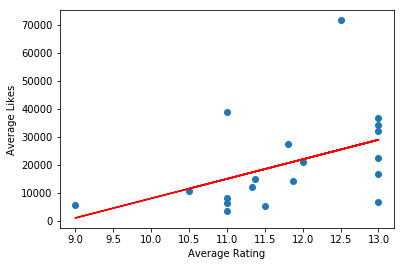

In [67]:
plt.scatter(df_mean_ratings_likes.ratings, df_mean_ratings_likes.likes);
plt.plot(df_mean_ratings_likes.ratings, df_mean_ratings_likes.ratings * 6977 - 61710, color='red');
plt.xlabel('Average Rating');
plt.ylabel('Average Likes');

P-value is quite small, 5%, so we can say they do weakly correlate and the relation is statistically significant. Now let's see if it holds for retweets.

In [68]:
sm.OLS(df_mean_ratings_likes.retweets, df_mean_ratings_likes[['ratings', 'intercept']], missing='drop').fit().summary()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               retweets   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     3.530
Date:                Sun, 09 Dec 2018   Prob (F-statistic):             0.0775
Time:                        11:40:11   Log-Likelihood:                -188.49
No. Observations:                  19   AIC:                             381.0
Df Residuals:                      17   BIC:                             382.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ratings     2096.1514   1115.716      1.879      0.078    -257.803    4450.106
intercept  -1.872e+04   1.32e+04     -1.418      0.174   -4.66e+04    9127.448
==============================================================================
Omnibus:                        3.499   Durbin-Watson:                   2.241
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                2.213
Skew:                           0.835   Prob(JB):                        0.331
Kurtosis:                       3.062   Cond. No.                         132.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

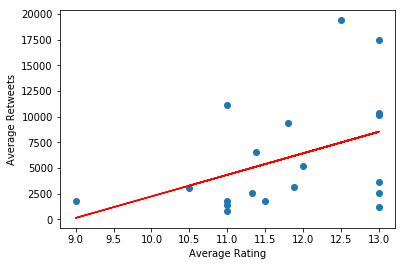

In [69]:
plt.scatter(df_mean_ratings_likes.ratings, df_mean_ratings_likes.retweets);
plt.plot(df_mean_ratings_likes.ratings, df_mean_ratings_likes.ratings * 2096 - 18720, color='red');
plt.xlabel('Average Rating');
plt.ylabel('Average Retweets');

Again, P-value is not much better, 7.8% so we can conclude they to weakly correlate in a statistically significant way.

Next, we'll see what's the popularity distribution of each dog type.

In [70]:
type_ratings = extractRatingByParameter(df_dog_data[['rating_numerator', 'dog_type']])
type_ratings_mean = {b:type_ratings[b].mean() for b in type_ratings.keys()}
type_ratings_mean

{'doggo': 12.225806451612904,
 'puppo': 12.055555555555555,
 'pupper': 11.065420560747663,
 'floofer': 11.857142857142858}

Let's visualise this.

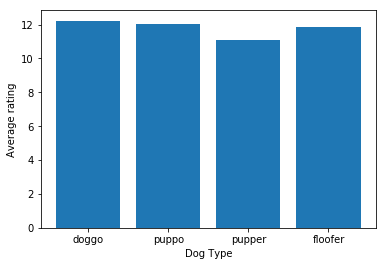

In [71]:
plt.bar(list(type_ratings_mean.keys()), list(type_ratings_mean.values()));
plt.xlabel('Dog Type');
plt.ylabel('Average rating');

We can see that `doggo` is an indisputable leader, the goodest of the boys and girls.

Let's build the linear regression for dog types and tweet data and see if there is actually a statistically significant difference.

In [72]:
df_dog_data_w_dummies = df_dog_data.join(pd.get_dummies(df_dog_data.dog_type)).join(df_tweet_data.set_index('tweet_id'))
df_dog_data_w_dummies = df_dog_data_w_dummies.dropna()
df_dog_data_w_dummies['intercept'] = 1

sm.OLS(df_dog_data_w_dummies['likes'], df_dog_data_w_dummies[['intercept', 'doggo', 'puppo', 'pupper']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  likes   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.507
Date:                Sun, 09 Dec 2018   Prob (F-statistic):              0.220
Time:                        11:40:12   Log-Likelihood:                -914.93
No. Observations:                  80   AIC:                             1838.
Df Residuals:                      76   BIC:                             1847.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.623e+04   1.03e+04      1.578      0.119   -4258.903    3.67e+04
doggo       6270.9692   1.12e+04      0.558      0.578   -1.61e+04    2.86e+04
puppo       8252.6706   1.17e+04      0.705      0.483   -1.51e+04    3.16e+04
pupper     -4208.6438   1.11e+04     -0.380      0.705   -2.62e+04    1.78e+04
==============================================================================
Omnibus:                       81.036   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              645.326
Skew:                           3.221   Prob(JB):                    7.40e-141
Kurtosis:                      15.333   Cond. No.                         9.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
sm.OLS(df_dog_data_w_dummies['rating_numerator'], df_dog_data_w_dummies[['intercept', 'doggo', 'puppo', 'pupper']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       rating_numerator   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.213
Date:                Sun, 09 Dec 2018   Prob (F-statistic):             0.0934
Time:                        12:07:15   Log-Likelihood:                -132.42
No. Observations:                  80   AIC:                             272.8
Df Residuals:                      76   BIC:                             282.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.2000      0.581     20.993      0.000      11.043      13.357
doggo         -0.0077      0.635     -0.012      0.990      -1.272       1.256
puppo         -0.2000      0.661     -0.303      0.763      -1.517       1.117
pupper        -0.8250      0.625     -1.320      0.191      -2.070       0.420
==============================================================================
Omnibus:                        3.452   Durbin-Watson:                   1.138
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                3.019
Skew:                          -0.381   Prob(JB):                        0.221
Kurtosis:                       2.429   Cond. No.                         9.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the above result we can conclude that there's weak and statistically insignificant correlation between dog types and the rating they receive. "They're Good Dogs Brent".

# Appendix

[1] - Tidy data https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html